# TP6 : Problème de Neumann/Dirichlet

In [165]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from numpy import linalg as LA 
import scipy
import scipy.linalg
from scipy.linalg import toeplitz 
from scipy.sparse import csr_matrix 
from scipy.sparse.linalg import spsolve

## Previous functions 

In [194]:
def LoadVTX(nom_du_fichier):
    f=open(nom_du_fichier,'r')
    f.readline() #on lit $Noeuds, que l'on ignore 
    nbr_vtx=int(f.readline()) #on converti en int la valeur lue par f : c'est le nombre de noeuds 
    resultat=[] # crée une liste vide permettant de stocker les coordonnées des noeuds 
    for i in range(nbr_vtx)  : 
        ligne=f.readline()
        tableau=ligne.split()
        couple=[]
        couple.append(float(tableau[1])) #conversion en float car on lit des str 
        couple.append(float(tableau[2]))
        resultat.append(couple)
    f.close()
    return resultat

def LoadELT(nom_du_fichier) :
    f=open(nom_du_fichier,'r')
    f.readline()
    nbr_vtx=int(f.readline())
    for i in range (nbr_vtx+2) : 
        f.readline()
    nbr_elt=int(f.readline())
    resultat=[]
    for i in range(nbr_elt) : 
        ligne=f.readline()
        tableau=ligne.split()
        triangle=[]
        triangle.append(int(tableau[1])) #conversion en float car on lit des str 
        triangle.append(int(tableau[2]))
        triangle.append(int(tableau[3]))
        resultat.append(triangle)
    f.close()
    return resultat


def Boundary(elt):
    D = {} #Dictionnaire vide visant à contenir les arêtes sur le bord ainsi la table de correspondance 
    Nc = len(elt) #Nombre de cellules 

    for i in range(Nc):
        
        s0 = int(elt[i][0]) 
        s1 = int(elt[i][1])  
        s2 = int(elt[i][2]) 
        
        b0=(s0,s1) #arête n°2
        b1=(s1,s2) #arête n°0
        b2=(s2,s0) #arête n°1 
        L = (b0,b1,b2) #Liste contenant les 3 arêtes du i-ème triangle 
    

        for k,b in zip([2,0,1], L):
            if b not in D.keys(): #Si l'arête b n'est pas dans D on l'ajoute avec la clée suivante. 
                D[b] = 3*i+k
            else : #Si b est déjà dans D, elle apparait plusieurs fois donc n'est pas dans le bord. 
                D.pop(b)
            if b[::-1] in D.keys(): #Si l'inverse de b est dans D, on enlève b et son inverse. 
                D.pop(b[::-1])
                D.pop(b)
        
    
    eltb = list(D.keys())
    be2e = list(D.values())
    #Conversion des list en tableaux numpy 
    eltb = np.array(eltb)
    be2e = np.array(be2e)
        
    #return eltb,be2e 
    return eltb #Ici seul eltb nous interesse.


def PlotMesh(vtx,elt) : 
    X = [vtx[i][0] for i in range(len(vtx))]
    Y = [vtx[j][1] for j in range(len(vtx))]
    plt.triplot(X,Y,elt)
    nb_elements = len(elt)
    plt.title(fr"Maillage à ${nb_elements}$ éléments.")
    #plt.axis('equal')

def PlotMeshBoundary(vtx, eltb) : 
    
    for e in eltb : #on boucle sur toutes les arêtes dans le bord 
        P1=e[0] #premier sommet de l'arête 
        P2=e[1] #second sommet de l'arête 
        x1=vtx[P1][0] #on extrait la première coordonnée du premier sommet de l'arête 
        y1=vtx[P1][1] #on extrait la seconde coordonnée du premier sommet de l'arête 
        x2=vtx[P2][0]
        y2=vtx[P2][1]
        plt.plot([x1,x2],[y1,y2])
    plt.title("Maillage avec PlotMeshBoundary")    
    plt.show() 
    

def PlotMesh_surcharged(vtx, elt, val = None):
    if val is None:
        val = np.zeros(len(vtx))
    
    X = [vtx[i][0] for i in range(len(vtx))]
    Y = [vtx[j][1] for j in range(len(vtx))]
    plt.tripcolor(X, Y, val, triangles=elt)
    nb_elements = len(elt)
    plt.title(fr"Maillage à {nb_elements} éléments.")
    #plt.axis('equal')
    plt.colorbar(label='Valeur')
    plt.show()

## Exercice 1 

In [195]:
def GenerateRectangleMesh(Lx, Ly, Nx, Ny):
    vtx = [] #Liste vide visant à contenir les sommets du maillage.
    elt = [] #Liste vide visant à contenir les cellules du maillage. 
    Nv = (Nx+1) * (Ny+1) #Cas particulier des maillages sur un rectangle 
    
    hx = Lx/Nx #Pas de la subdivision sur l'axe des abscisses. 
    hy = Ly/Ny #Pas de la subdivision sur l'axe des ordonnées. 
    x = 0. 
    y = 0.
    noeuds = 0
    kx = 0
    while noeuds < Nv:
        vtx.append([x,y])
        
        if kx==Nx:
            x=0.
            kx=0
            y+=hy
            
        else:
            x+=hx
            kx+=1
            
        noeuds+=1

    for j in range(Ny):
        for i in range(Nx):
            s0 = j*(Nx+1) + i
            s1 = j*(Nx+1) + i+1
            s2 = (j+1) * (Nx+1) + i+1
            elt.append( [ s0, s1, s2 ] ) #Triangle inférieur (en dessous de la diagonale).

            s0 = j*(Nx+1) + i 
            s1 = (j+1) * (Nx+1) + i+1 
            s2 = (j+1) * (Nx+1) + i
            elt.append( [ s0, s1, s2] ) #Triangle supérieur.
            
    return vtx,elt

In [196]:
vtx, elt = GenerateRectangleMesh(2*np.pi, np.pi, 10,10)

> **Question 1:**

In [300]:
def Normal(vtx, belt):
    vtx = np.array(vtx)
    nb_belt = len(belt)
    nrm = np.zeros((nb_belt, 2))
    for i in range(nb_belt):
        v = vtx[belt[i][1]] - vtx[belt[i][0]]
        nrm[i] = np.array([v[1], -v[0]])
    return nrm

vtx = LoadVTX("maillage1.msh")
elt = LoadELT("maillage1.msh")

belt = Boundary(elt)
print(Normal(vtx,belt))

[[ 0. -1.]
 [-1. -0.]
 [ 0. -1.]
 [ 0. -1.]
 [ 1. -0.]
 [ 0.  1.]
 [-1. -0.]
 [ 0.  1.]
 [ 1. -0.]
 [ 0.  1.]]


> **Question 2.**

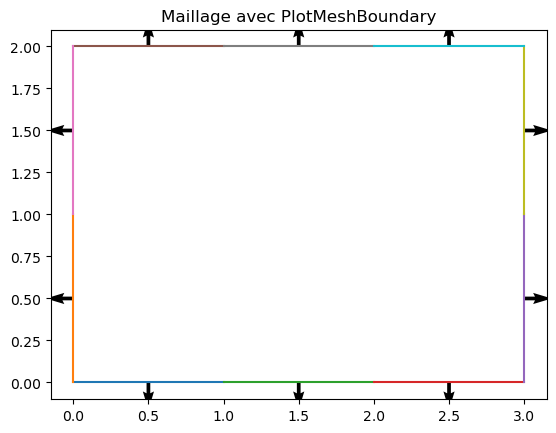

In [301]:
n = Normal(vtx,belt)
nb_bord = len(belt)

for k in range (nb_bord) : 
    a = vtx[belt[k][0]]
    b = vtx[belt[k][1]]
    v = [(a[i] + b[i]) / 2 for i in range(len(a))]  # milieu
    plt.quiver(v[0],v[1], n[k,0], n[k,1])
PlotMeshBoundary(vtx,belt)

## Exercice 3

> **Question 1.**

In [334]:
def f(x,y) : 
    return np.sin(x)*np.sin(y)

mu = 2
Nx = Ny = 10
Lx = 2*np.pi
Ly = np.pi

Par définition : 
$$ \Delta f = \dfrac{\partial^2f}{\partial x^2} + \dfrac{\partial^2f}{\partial y^2}.$$
Ainsi il est facile de remarquer que $\Delta f = -2\sin(x)\sin(y) = -2f$.

Remarquons également que $f_{|\partial \Omega} = 0. $
Soit $u = c\times f$, où $ c\in \mathbb{C}$. Alors $$-\Delta u + \mu^2 u = f $$
$$\Leftrightarrow 2cf+\mu^2cf = f$$
$$\Leftrightarrow c = \dfrac{1}{1+\mu^2}$$
Il vient alors que $u_{ex}^D(x,y) = \dfrac{1}{1+\mu^2}f(x,y)$. 

In [335]:
def u(x,y) :
    return 1/(1+mu**2)*f(x,y)

> **Question 2.** Résolution par éléments finis $\mathbb{P}_1-$Lagrange. 

En tenant compte de la condition au bord de Dirichlet homogène, on choisit comme espace 
variationnel $H_0^1(\Omega) := \text{ker}(\tau_{\partial \Omega})$.
Dans l'écriture de $(BVM)$ on suppose tacitement que $\nabla u \in H(\text{div},\Omega)$.
Autrement dit, on impose plus que simplement $u \in H^1(\Omega)$. En réalité $u \in H^1(\Omega)\cap H^1(\Delta,\Omega)$.

En multipliant l'EDP du volume de $\Omega$ par $v \in H_0^1(\Omega)$ puis en intégrant : 

$$ \int_{\Omega} -\bar{v}\Delta u + \mu^2u\bar{v}\,dx = \int_{\Omega} f\bar{v} \, dx$$

En utilisant la formule de Green (dont l'utilisation est permise car $\nabla u \in H(\text{div},\Omega)$) et en tenant compte de la nullité sur le bord, on a :  

$$\int_{\Omega} \nabla \bar{v}^t \nabla u + \mu^2u\bar{v} \,dx = \int_{\Omega} f\bar{v} \, dx$$

$$\Longleftrightarrow a(u,v)=l(v)$$

On obtient alors la formulation variationelle suivante : 

$$(VF) : \left\{
    \begin{array}{l}
        \text{Trouver } u \in H^1_0(\Omega) \text{ tel que :} \\
        a(u,v) = l(v) \quad \forall v \in H^1_0(\Omega)
    \end{array}
\right.
$$

**Construction du membre de gauche + assemblage :**

In [336]:
def Mloc(vtx, e) : 
    if(len(e)==3) : 
        mat=toeplitz(np.array([2,1,1]))/12
        #L'aire du triangle ABC est par définition la norme du produit vectoriel AB v AC 
        """ 
        Écrire ici : 
        T=LA.norm(np.cross(vtx[e[0]] - vtx[e[1]], vtx[e[1]] - vtx[e[2]]))/2
        L'opérateur - n'étant pas défini pour les list 
        On doit convertir les list en tableau numpy pour les soustraire 
        """
        T=LA.norm(np.cross(np.array(vtx[e[0]]) - np.array(vtx[e[1]]), np.array(vtx[e[1]]) - np.array(vtx[e[2]])))/2 # par défaut la norme 2
        #print (T)
    
        return T*mat

def Mass(vtx, elt) :
    
    vtx = np.array(vtx)
    elt = np.array(elt)
    
    Nv=len(vtx) #Nombre de sommets.
    
    Nc=len(elt) #Nombre de cellules.
    d=len(elt[0]) 
    
    #print ("Nv={}".format(Nv))
    #print("Nc={}".format(Nc))
    #print("d={}".format(d))
    
    I = np.zeros(d*d*Nc)
    J = np.zeros(d*d*Nc)
    V = np.zeros(d*d*Nc)
    
    k=0 
    
    for q in range(Nc):
        Ml = Mloc(vtx, elt[q])
        for l in range(d):
            for m in range(d):
                I[k] = elt[q,l]
                J[k] = elt[q,m]
                V[k] = Ml[l,m]
                k+=1
    return csr_matrix( (V, (I,J) ) , shape=(Nv,Nv) )

In [337]:
print(Mass(vtx,elt).toarray())
U = np.ones(len(vtx))
print("Volume du domaine : ", 2*np.pi**2)
print("Test sur la masse : ",U@Mass(vtx,elt)@U)

[[0.03289868 0.00822467 0.         ... 0.         0.         0.        ]
 [0.00822467 0.04934802 0.00822467 ... 0.         0.         0.        ]
 [0.         0.00822467 0.04934802 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.04934802 0.00822467 0.        ]
 [0.         0.         0.         ... 0.00822467 0.04934802 0.00822467]
 [0.         0.         0.         ... 0.         0.00822467 0.03289868]]
Volume du domaine :  19.739208802178716
Test sur la masse :  19.739208802178705


In [338]:
def Kloc(vtx,e) : 
    vtx = np.array(vtx)
    d = len(e) # dimension
    s = vtx[e] # sommets de l'élément e 
    K = np.zeros((d,d)) # matrice carée de taille d x d remplie de 0, à remplir ensuite
    T = LA.norm(np.cross(np.array(vtx[e[0]]) - np.array(vtx[e[1]]), np.array(vtx[e[1]]) - np.array(vtx[e[2]])))/2
    
    for i in range(d) : 
        for j in range(d) : 
            K[i,j] = np.inner(s[(i+1)%3]-s[(i+2)%3],s[(j+1)%3]-s[(j+2)%3])
    K/=(4*T)
    return K 

In [339]:
def Rig(vtx, elt) :
    
    vtx = np.array(vtx)
    elt = np.array(elt)
    
    Nv=len(vtx) #Nombre de sommets. 
    
    Nc=len(elt) #Nombre de cellules. 
    d=len(elt[0]) 
    
    #print ("Nv={}".format(Nv))
    #print("Nc={}".format(Nc))
    #print("d={}".format(d))

    I = np.zeros(d*d*Nc) #Pour les lignes.
    J = np.zeros(d*d*Nc) #Pour les colonnes. 
    V = np.zeros(d*d*Nc)
    
    k=0 
    
    for q in range(Nc):
        Ml = Kloc(vtx, elt[q])
        for l in range(d):
            for m in range(d):
                I[k] = elt[q,l]
                J[k] = elt[q,m]
                V[k] = Ml[l,m]
                k+=1
    return csr_matrix( (V, (I,J) ) , shape=(Nv,Nv) )

In [340]:
print("Test sur le ridigité", U@Rig(vtx,elt)@U)

Test sur le ridigité 0.0


In [341]:
def A0(mu,Lx,Ly,Nx,Ny) :
    vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny) 
    K = Rig(vtx,elt)
    M = Mass(vtx,elt)
    return K + mu**2*M

La matrice $A^0$ obtenue ne convient pas totalement au problème posé. Il faut pour cela utiliser la "pseudo-élimination" afin de, encore une fois, traiter différement les termes de bord. Pour ce faire, il faut "isoler" les noeuds sur le bord, en mettant à 0 les lignes / colonnes, et à 1 le coefficient diagonal. Il faudra bien sûr adopter un traitement similaire dans le second membre (en mettant à 0 à l'indice correspondant aux  sommets concernés). À la fin, on obtiendra obtenir la condition de bord sans dépendre des autres valeurs dans la forme matricielle, en "forçant" en quelque sorte les solutions à s'annuler sur le bord. C'est la raison pour laquelle au lieu de mettre 1 sur le terme diagonal, on aurait en réalité pu mettre n'importe quel $x \in \mathbb{R}^*$.

In [343]:
def A(mu,Lx,Ly,Nx,Ny) : 
    vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny) 
    A_0 = A0(mu, Lx,Ly,Nx,Ny)
    Nv = A_0.shape[0] #nombre de sommets dans le maillage 
    d = len(elt[0]) #dimension 
    Nc = len(vtx) #nombre de cellules dans le maillage 
    bord = Boundary(elt) #arètes sur le bord 
    A1 = csr_matrix(A_0)
    for i in range(Nv) : #pesudo-élimination 
        if i in bord : 
            A1[i,:]=0
            A1[:,i]=0
            A1[i,i] = 1 
    return csr_matrix(A1)

print(A(mu,Lx,Ly,Nx,Ny).toarray())

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


**Construction du membre de droite :**

On choisit ici la règle de quadrature suivante : 

$$\int_{\tau} g(x) \, dx \approx g\left(\frac{s_0^{\tau}+s_1^{\tau}+s_2^{\tau}}{3}\right)|\tau|$$


On appliquant à $g=f\varphi_j$, où $\varphi_j$ fonction de forme. 

On remarque que $\varphi_j\left(\dfrac{s_0^{\tau}+s_1^{\tau}+s_2^{\tau}}{3}\right) = \dfrac{1}{3}$. Montrons le.

En effet, $\varphi_j$ est linéaire.  
Donc $\varphi_j = a^Tx+b$, où $a \in \mathbb{C}^2$ et $b \in \mathbb{C}$

Prenons le simplexe $\tau$ de sommets $s_j^{\tau},s_{j+1}^{\tau},s_{j+2}^{\tau}$. 
Par définition, $\varphi(s_j^{\tau})=1$, donc $a^Ts_j^{\tau}=1-b$.
De même, comme $\varphi(s_{j+1}^{\tau})=0$ et $\varphi(s_{j+2}^{\tau})=0$, on a $a^Ts_{j+1}^{\tau}=-b$ et $a^Ts_{j+2}^{\tau}=-b$. 
$\newline$
Au final par linéarité : 
$$\phi_j\left(\frac{s_j^{\tau}+s_{j+1}^{\tau}+s_{j+2}^{\tau}}{3}\right) = \frac{1}{3}(1-b-b-b)+b = \frac{1}{3}$$

Pour construire le second membre, on va suivre la même idée que pour assembler la matrice de masse / rigidité. 
Créons une fonction locale, puis à l'aide de celle-ci une fonction globale en ajoutant chaque contribution. Ici j'ai fait le choix d'incorporer directement la pseudo-elimination au coeur de l'assemblage (contrairement au membre de gauche où j'ai implémenté $A^0$). 

In [344]:
def F_loc(vtx,e): 
    vtx = np.array(vtx)
    d = len(e) 
    s = vtx[e] #Sommets de l'élément e. 
    T = LA.norm(np.cross(np.array(vtx[e[0]]) - np.array(vtx[e[1]]), np.array(vtx[e[1]]) - np.array(vtx[e[2]])))/2
    F = np.zeros(d)
    for i in range (d) : 
            F[i] = f((s[0][0]+s[1][0]+s[2][0])/3,(s[0][1] +s[1][1]+s[2][1])/3)*T/3
    return F 

In [345]:
def F_global(Lx, Ly, Nx, Ny) : 
    vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
    vtx = np.array(vtx)
    elt = np.array(elt)
    Nv = len(vtx) #Nombre de sommets. 
    Nc = len(elt) #Nombre de cellules. 
    d=len(elt[0]) 
    F1 = np.zeros(Nv)
    bord = Boundary(elt)
    F1 = np.array(F1)
    for q in range(Nc):
        Fl = F_loc(vtx, elt[q])
        for l in range(d):        
            j = elt[q,l] 
            F1[j] += Fl[l] 
    #Prise en compte des conditions de Dirichlet : pseudo-élimination. 
    for i in range(Nv) : 
        if i in bord : 
            F1[i]=0
    return F1 

In [346]:
F_global(2*np.pi, np.pi, 10, 10)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.71591494e-02,  5.61192036e-02,  5.36436295e-02,  3.06780122e-02,
       -4.00556307e-03, -3.71591494e-02, -5.61192036e-02, -5.36436295e-02,
       -3.06780122e-02,  0.00000000e+00,  0.00000000e+00,  6.72735669e-02,
        1.05443582e-01,  1.03337733e-01,  6.17603823e-02, -3.40733547e-03,
       -6.72735669e-02, -1.05443582e-01, -1.03337733e-01, -6.17603823e-02,
        0.00000000e+00,  0.00000000e+00,  9.08027789e-02,  1.44446408e-01,
        1.42916419e-01,  8.67972158e-02, -2.47557412e-03, -9.08027789e-02,
       -1.44446408e-01, -1.42916419e-01, -8.67972158e-02,  0.00000000e+00,
        0.00000000e+00,  1.05443582e-01,  1.69309814e-01,  1.68505451e-01,
        1.03337733e-01, -1.30148634e-03, -1.05443582e-01, -1.69309814e-01,
       -1.68505451e-01, -

**Résolution du système linéaire:**

In [347]:
def Uh(mu,Lx,Ly,Nx,Ny) :  
    return spsolve (A(mu,Lx,Ly,Nx,Ny), F_global(Lx,Ly,Nx,Ny))

In [348]:
Uh(mu,Lx,Ly,Nx,Ny)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.04911829e-02,  4.92714594e-02,  4.92216366e-02,  3.03691857e-02,
       -8.35360412e-05, -3.05044332e-02, -4.92739151e-02, -4.92238675e-02,
       -3.03812641e-02,  0.00000000e+00,  0.00000000e+00,  5.79596855e-02,
        9.37024246e-02,  9.36406452e-02,  5.78090699e-02, -1.03988495e-04,
       -5.79774575e-02, -9.37059202e-02, -9.36442163e-02, -5.78270423e-02,
        0.00000000e+00,  0.00000000e+00,  7.97379018e-02,  1.28953481e-01,
        1.28901814e-01,  7.96121237e-02, -8.70111892e-05, -7.97530379e-02,
       -1.28956556e-01, -1.28905383e-01, -7.96290634e-02,  0.00000000e+00,
        0.00000000e+00,  9.37035947e-02,  1.51578511e-01,  1.51549527e-01,
        9.36328700e-02, -4.84910166e-05, -9.37114072e-02, -1.51580077e-01,
       -1.51551903e-01, -

> **Question 3.**

In [349]:
def PlotApproximation(mu,Lx,Ly,Nx,Ny) : 
    U = Uh(mu,Lx,Ly,Nx,Ny) #Solution approchée. 
    vtx, elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
    vtx = np.array(vtx) #Conversion en tableau numpy (bi-dimensionnel). 
    X = vtx[:,0] #Abscisses.
    Y = vtx[:,1] #Ordonnées.
    triangulation = mtri.Triangulation(X,Y,elt) 
    plt.tripcolor(triangulation, U,label="Solution approchée")
    plt.title("Solution approchée, Nx={} et Ny={}".format(Nx,Ny))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.colorbar()
    
    

def PlotSolutionExacte(mu,Lx,Ly,Nx,Ny):
    vtx, elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
    vtx = np.array(vtx)
    X = vtx[:,0] #Abscisses.
    Y = vtx[:,1] #Ordonnées.
    triangulation = mtri.Triangulation(X, Y, elt)
    Uex = np.array([u(x,y) for (x,y) in vtx]) #Solution exacte. 
    plt.tripcolor(triangulation, Uex,label="Solution Exacte")
    plt.title("Solution exacte,Nx={} et Ny={}".format(Nx,Ny))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.colorbar()

 
    
def PlotErreur(mu,Lx,Ly,Nx,Ny):
    vtx, elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
    vtx = np.array(vtx)
    X = vtx[:,0]
    Y = vtx[:,1]
    U = Uh(mu,Lx,Ly,Nx,Ny) #Solution approchée.
    triangulation = mtri.Triangulation(X, Y, elt)
    Uex = np.array([u(x,y) for (x,y) in vtx]) #Solution exacte. 
    plt.tripcolor(triangulation, abs(Uex-U), shading='flat',label="Erreur")
    plt.title("Erreur en valeur absolue, Nx={} et Ny={}".format(Nx,Ny))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.colorbar()
    
 

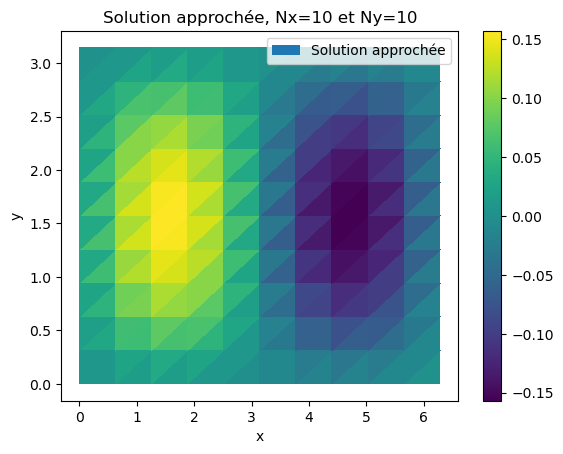

In [350]:
PlotApproximation(mu,Lx,Ly,Nx,Ny)

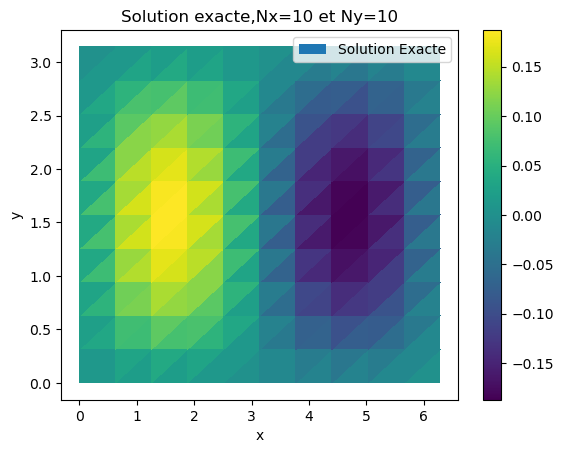

In [351]:
PlotSolutionExacte(mu,Lx,Ly,Nx,Ny)

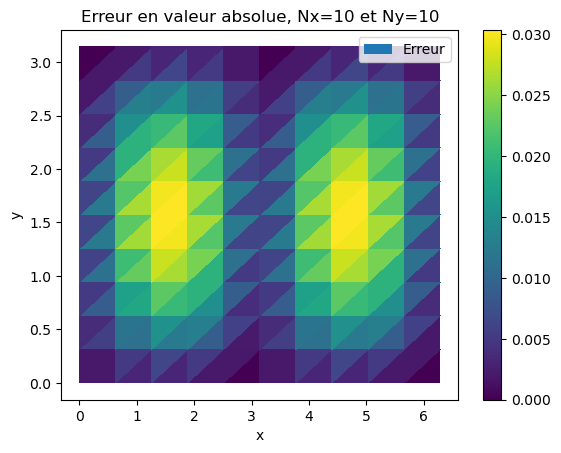

In [352]:
PlotErreur(mu,Lx,Ly,Nx,Ny)

> **Question 4.** $\| f \|_{L^2(\Omega)}^2 = \displaystyle \int_0^{2\pi}\displaystyle \int_0^{\pi} \sin^2(x)\sin^2(y) \, dx\, dy = \dfrac{\pi^2}{2}$

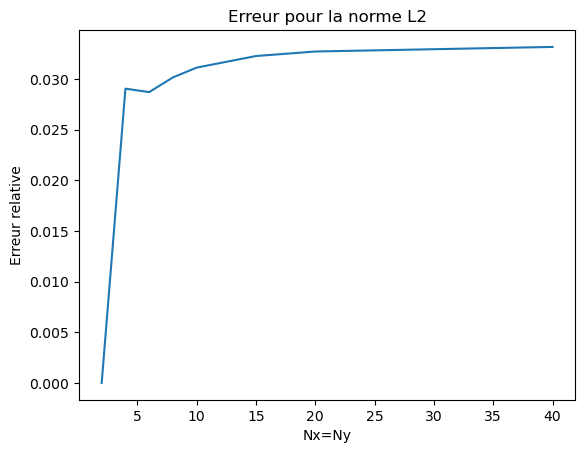

[0.00042696 0.02155288]


In [353]:
mu = 2 

def PlotErreurL2(mu,Lx,Ly):
    N_values = [[2,2],[4,4],[6,6], [8,8],[10,10],[15,15],[20,20], [40,40]] #Par exemple. 
    H = [] #Pour les abcisses : nombre de subdivisions. 
    E = [] #Pour les ordonnées : erreur observée. 
    erreur = 0
    
    for Nx, Ny in N_values:
        H.append(Nx)
        vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
        M = Mass(vtx, elt)
        Uex = np.array([ u(x,y) for (x,y) in vtx ]) #Solution exacte.
        U = Uh(mu,Lx,Ly,Nx,Ny) #Solution approchée.
        erreur = 2*( (U-Uex).dot(M.dot(U-Uex)) )/ ( np.pi**2 )
        E.append(erreur**0.5) #Car on avait le carré de la norme. 
        
    plt.plot(H,E)
    plt.title("Erreur pour la norme L2")
    plt.xlabel('Nx=Ny')
    plt.ylabel('Erreur relative')
    plt.show()
    return np.polyfit(H, E, 1) #Le 1 dans l'argument signifie régréssion d'ordre 1 (linéaire)

""" 
Si on voulait une echelle log-log : 
- On remplace plt.plot(H,E) par plt.loglog(H,E)
- On remplace return np.polyfit(H, E, 1) par #return np.polyfit(np.log(H), np.log(E), 1)
"""

Lx = 2*np.pi
Ly = np.pi

print(PlotErreurL2(mu,Lx,Ly))